# Correlate GC-MS and Sensory Data

In [6]:
import pandas as pd
import numpy as np

# Statistics
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from scipy.spatial import procrustes

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

## Load data

In [7]:
Sensory_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/curated_data/Sensory_data_median_renamed.csv', index_col=1)
Sensory_data.drop(columns='Unnamed: 0', inplace=True)
Sensory_data.head()

,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,Mineral,Reduction,...,Olfactory_complexity,CO2,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length
Sample,,,,,,,,,,,,,,,,,,,,,
2022_Plot4,4.96,0.6150,2.265,3.600,1.5650,0.1250,0.690,0.095,0.140,0.3650,...,3.130,0.145,4.475,3.425,1.050,1.865,2.800,1.770,3.165,4.655
2022_Plot5,5.16,0.2300,0.405,1.665,0.1850,0.0500,0.140,0.730,0.940,0.1300,...,3.315,0.130,4.775,3.020,3.830,3.050,1.340,2.200,2.700,5.060
2022_Plot9,4.58,0.0405,2.185,1.740,0.0950,0.1200,2.055,0.965,1.295,0.1300,...,3.395,0.115,4.680,2.565,2.135,1.280,2.735,0.925,3.535,4.670
2022_Plot12,4.10,0.1050,0.520,2.545,0.1500,0.0800,1.175,1.920,0.995,0.0855,...,3.315,0.105,5.380,2.725,1.560,2.140,2.640,1.380,3.395,4.765
2022_Plot13,4.52,0.0105,0.445,2.455,0.0255,0.0505,0.545,1.980,2.915,0.7350,...,2.940,0.145,4.085,2.690,1.430,0.680,1.340,2.010,2.470,2.790


The GC MS data is already normalizesd, but Sensory not. 

Normalizing BOTH has also been done here: Robinson, A. L., Adams, D. O., Boss, P. K., Heymann, H., Solomon, P. S., & Trengove, R. D. (2011). The relationship between sensory attributes and wine composition for Australian Cabernet Sauvignon wines. Australian Journal of Grape and Wine Research, 17(3), 327-340.

> Tried analysis with both and it doesn't change the result 

In [8]:
### TSN normalization
sum_per_profile = Sensory_data.sum(axis=0)
# Apply Total Sum Normalization by dividing each value by the sum of its corresponding column
Sensory_data_normalized = Sensory_data.div(sum_per_profile, axis=1)

In [9]:
GC_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Metabolomics/GC-MS/GC-2022-forCorrelation.csv',index_col=1)
GC_data.drop(columns='Unnamed: 0', inplace=True)
# drop cols with NaN
GC_data_cleaned = GC_data.dropna(axis=1)
GC_data_cleaned

,Nonanoic acid,"(5Z)-Octa-1,5-dien-3-ol",(S)-(+)-6-Methyl-1-octanol,"1,2-Benzenedicarboxylic acid, bis(2-methylpropyl) ester","1,3-Propanediol, diacetate",1-Butanol,"1-Butanol, 2-methyl-","1-Butanol, 3,3-dimethyl-","1-Butanol, 3-methyl-","1-Butanol, 3-methyl-, acetate",...,Phenethyl alcohol,"Propanoic acid, 2-hydroxy-, ethyl ester, (S)-","Propanoic acid, 2-methyl-",Tetradecane,"Undecanoic acid, ethyl ester",VARAMOL 106 YLBICYCLO[2HYLENE]R]ETHYLPHENYL ESTER]],trans-Geranylacetone,trans-Nerolidol,ß-Citronellol,ß-Damascenone
Name,,,,,,,,,,,,,,,,,,,,,
2022_Plot12,0.0,0.000000,0.0,0.0,0.0,0.0,0.024054,0.0,0.044875,0.016159,...,0.311974,0.002356,0.0,0.0,0.000000,0.0,0.0,0.001088,0.000000,0.0
2022_Plot13,0.0,0.004390,0.0,0.0,0.0,0.0,0.022118,0.0,0.032496,0.019365,...,0.209359,0.012090,0.0,0.0,0.000000,0.0,0.0,0.001397,0.000000,0.0
2022_Plot14,0.0,0.000000,0.0,0.0,0.0,0.0,0.018272,0.0,0.011981,0.015306,...,0.276638,0.006937,0.0,0.0,0.001716,0.0,0.0,0.000875,0.000000,0.0
2022_Plot15,0.0,0.000000,0.0,0.0,0.0,0.0,0.044060,0.0,0.048109,0.012508,...,0.311832,0.020765,0.0,0.0,0.000000,0.0,0.0,0.001063,0.000000,0.0
2022_Plot17,0.0,0.002725,0.0,0.0,0.0,0.0,0.027417,0.0,0.028306,0.000000,...,0.143403,0.020898,0.0,0.0,0.000831,0.0,0.0,0.000771,0.000000,0.0
2022_Plot19,0.0,0.002465,0.0,0.0,0.0,0.0,0.043103,0.0,0.080140,0.022655,...,0.122195,0.029160,0.0,0.0,0.000000,0.0,0.0,0.001037,0.000000,0.0
2022_Plot20,0.0,0.002186,0.0,0.0,0.0,0.0,0.029050,0.0,0.011582,0.014899,...,0.312749,0.017130,0.0,0.0,0.000000,0.0,0.0,0.000961,0.000000,0.0
2022_Plot4,0.0,0.004813,0.0,0.0,0.0,0.0,0.021898,0.0,0.048155,0.018337,...,0.130668,0.011828,0.0,0.0,0.000000,0.0,0.0,0.000995,0.001371,0.0
2022_Plot5,0.0,0.000000,0.0,0.0,0.0,0.0,0.028982,0.0,0.020190,0.017513,...,0.277093,0.025626,0.0,0.0,0.000000,0.0,0.0,0.000879,0.000000,0.0


In [10]:
#GC_data_cleaned.reset_index(inplace=True)
#GC_data_cleaned.rename(columns={"Name": "Sample"}, inplace=True)
#Sensory_data.reset_index(inplace=True)

# Canonical Correlation Analysis (CCA)

In [11]:
# Initialize CCA
cca = CCA(n_components=2) 

In [12]:
# Fit the data to the CCA model
cca.fit(Sensory_data, GC_data_cleaned)

# Transform the data: dimensionality reduction 
cca_df1, cca_df2 = cca.transform(Sensory_data, GC_data_cleaned)

#### Visualization

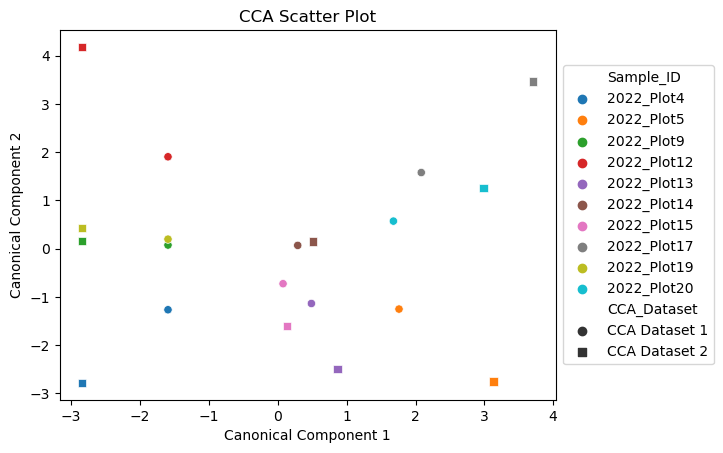

In [13]:
# Assuming cca_df1 and cca_df2 are your transformed DataFrames from CCA

#  sample_ids is a Series containing the Sample IDs corresponding to the rows of cca_df1 and cca_df2
sample_ids = pd.Series(Sensory_data.index)

# Combine the Sample IDs with the transformed DataFrames
cca_combined_df1 = pd.DataFrame(cca_df1, columns=['CCA_Component_1', 'CCA_Component_2'])
cca_combined_df1['Sample_ID'] = sample_ids
cca_combined_df1['CCA_Dataset'] = 'CCA Dataset 1'

cca_combined_df2 = pd.DataFrame(cca_df2, columns=['CCA_Component_1', 'CCA_Component_2'])
cca_combined_df2['Sample_ID'] = sample_ids
cca_combined_df2['CCA_Dataset'] = 'CCA Dataset 2'

cca_combined = pd.concat([cca_combined_df1, cca_combined_df2])

# Create the scatter plot
sns.scatterplot(x='CCA_Component_1', y='CCA_Component_2', data=cca_combined, hue='Sample_ID', style='CCA_Dataset', markers=['o', 's'])

plt.xlabel('Canonical Component 1')
plt.ylabel('Canonical Component 2')
plt.title('CCA Scatter Plot')
plt.legend(title='Sample ID')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# PLSR analysis 
according to Seisone et al (2016, https://doi.org/10.1016/j.foodchem.2016.04.134) the most common technique to correlate GC-MS and Sensory Data.

Estimated number of components in the Sensory (Y) PCA is 17 (> 21 original variables, see Sensory_Analysis.ipynb) ...  it means the Y-variables are correlated and a single PLS model for all Y-variables is warranted. 

### Determining Number of components 
#### Plot the percent of variance explained in the response variable as a function of the number of components
Ref: https://de.mathworks.com/help/stats/partial-least-squares-regression-and-principal-components-regression.html
Ten components may be more than will be needed to adequately fit the data, but diagnostics from this fit can be used to make a choice of a simpler model with fewer components. For example, one quick way to choose the number of components is to plot the percent of variance explained in the response variable as a function of the number of components.

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python

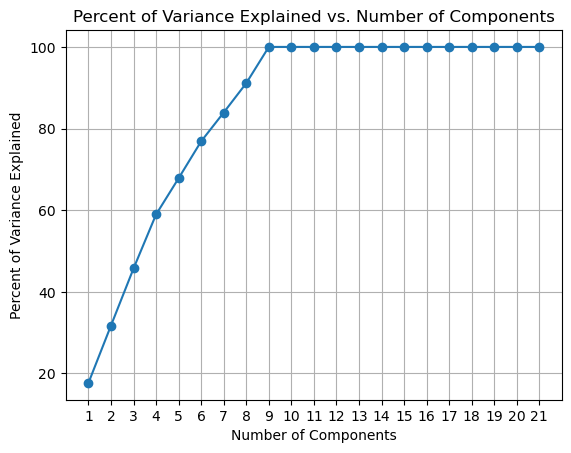

In [14]:
# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Initialize lists to store explained variance
explained_variances = []

# Define the maximum number of components to try
max_components = min(X.shape[1], Y.shape[1])  # Choose the minimum of the two sets of features

# Loop over different numbers of components
for n_components in range(1, max_components + 1):
    # Perform PLSR
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    
    # Calculate the total variance of Y
    total_variance_y = np.var(Y, axis=0).sum()
    
    # Calculate the residual variance of Y after PLSR
    Y_pred = pls.predict(X)
    residual_variance_y = np.var(Y - Y_pred, axis=0).sum()
    
    # Calculate the percent of variance explained
    explained_variance = (total_variance_y - residual_variance_y) / total_variance_y * 100
    explained_variances.append(explained_variance)

# Plot the percent of variance explained
plt.plot(range(1, max_components + 1), explained_variances, marker='o')
plt.title('Percent of Variance Explained vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Variance Explained')
plt.xticks(range(1, max_components + 1))
plt.grid(True)
plt.show()

#### Leave-one-out cross validatiaon to determine number of components included in PLSR analysis

It's often useful to choose the number of components to minimize the expected error when predicting the response from future observations on the predictor variables. Simply using a large number of components will do a good job in fitting the current observed data, but is a strategy that leads to overfitting. Fitting the current data too well results in a model that does not generalize well to other data, and gives an overly-optimistic estimate of the expected error.

In [15]:
# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
mse_scores = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Perform PLSR
    pls = PLSRegression(n_components=2)
    pls.fit(X_train, Y_train)
    
    # Predict on the test set
    Y_pred = pls.predict(X_test)
    
    # Calculate  
    mse = mean_squared_error(Y_test, Y_pred)
    mse_scores.append(mse)

# Calculate the mean MSE
mean_mse = np.mean(mse_scores)
print("Mean MSE using LOOCV:", mean_mse)

Mean MSE using LOOCV: 0.005603550696548886


### PLSR

In [16]:
# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Perform PLSR with 8 components
pls = PLSRegression(n_components=8)
pls.fit(X, Y)

# Get the transformed data
X_scores, Y_scores = pls.transform(X, Y)

# Convert transformed data back to pandas dataframes
X_scores_df = pd.DataFrame(X_scores, index=GC_data_cleaned.index, columns=[f'PLS{i+1}' for i in range(8)])
Y_scores_df = pd.DataFrame(Y_scores, index=Sensory_data_normalized.index, columns=[f'PLS{i+1}' for i in range(8)])

# Print or further analyze the transformed dataframes
print("Transformed data from GC:")
print(X_scores_df)
print("\nTransformed data from Sensory:")
print(Y_scores_df)

Transformed data from GC:
                 PLS1      PLS2      PLS3      PLS4      PLS5      PLS6  \
Name                                                                      
2022_Plot12 -3.139379 -3.546114  4.374620  2.637668 -1.772273 -3.939134   
2022_Plot13 -5.996189  7.416096  2.099956 -2.167193  1.812762 -0.607512   
2022_Plot14  4.967539 -1.850482  1.371920 -1.871121  4.544963  0.112511   
2022_Plot15 -1.842994 -1.857649 -0.737306 -3.991294 -2.983081  0.713044   
2022_Plot17  8.488829  5.723891  1.009686  2.026237 -2.574154  0.284350   
2022_Plot19 -3.239043 -1.027931  0.194642  1.948092 -2.054958  5.309294   
2022_Plot20  0.048787 -1.128505 -1.714442 -1.659847 -1.663733 -0.563106   
2022_Plot4  -2.765981  1.374308 -5.933151  2.768410  1.468243 -2.076332   
2022_Plot5   3.768010 -2.571911 -1.554957 -1.438764 -0.615738 -1.469905   
2022_Plot9  -0.289578 -2.531703  0.889033  1.747811  3.837968  2.236790   

                 PLS7      PLS8  
Name                             
2022_

#### Visualization: Biplot

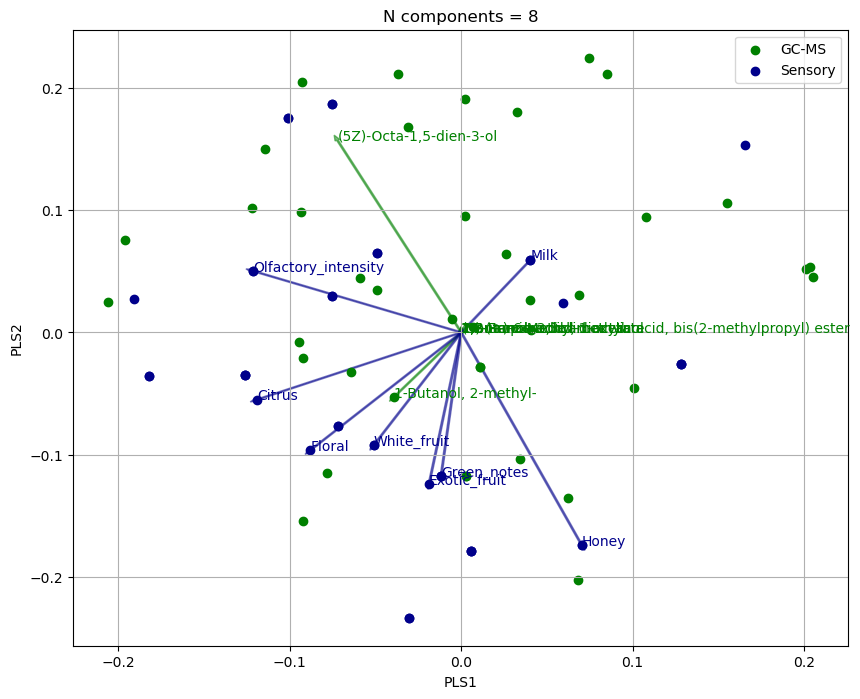

In [17]:
# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Standardize X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Perform PLSR with 8 components
pls = PLSRegression(n_components=8)
pls.fit(X_scaled, Y_scaled)

# Get the loadings
X_loadings = pls.x_loadings_
Y_loadings = pls.y_loadings_

# Get the top 5 loadings for X and Y
top_loadings_X_idx = np.argsort(np.abs(X_loadings), axis=0)[-5:]
top_loadings_Y_idx = np.argsort(np.abs(Y_loadings), axis=0)[-5:]

# Create biplot
plt.figure(figsize=(10, 8))
for i in range(X_loadings.shape[1]):
    plt.arrow(0, 0, X_loadings[i, 0], X_loadings[i, 1], color='g', alpha=0.5)
    plt.text(X_loadings[i, 0], X_loadings[i, 1], GC_data_cleaned.columns[i], color='g')
for i in range(Y_loadings.shape[1]):
    plt.arrow(0, 0, Y_loadings[i, 0], Y_loadings[i, 1], color='darkblue', alpha=0.5)
    plt.text(Y_loadings[i, 0], Y_loadings[i, 1], Sensory_data.columns[i], color='darkblue')

# Plot the top 5 loadings for X and Y
plt.scatter(X_loadings[top_loadings_X_idx, 0], X_loadings[top_loadings_X_idx, 1], color='g', marker='o', label='GC-MS')
plt.scatter(Y_loadings[top_loadings_Y_idx, 0], Y_loadings[top_loadings_Y_idx, 1], color='darkblue', marker='o', label='Sensory')

plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.title('N components = 8')
plt.legend()
plt.grid(True)
plt.show()


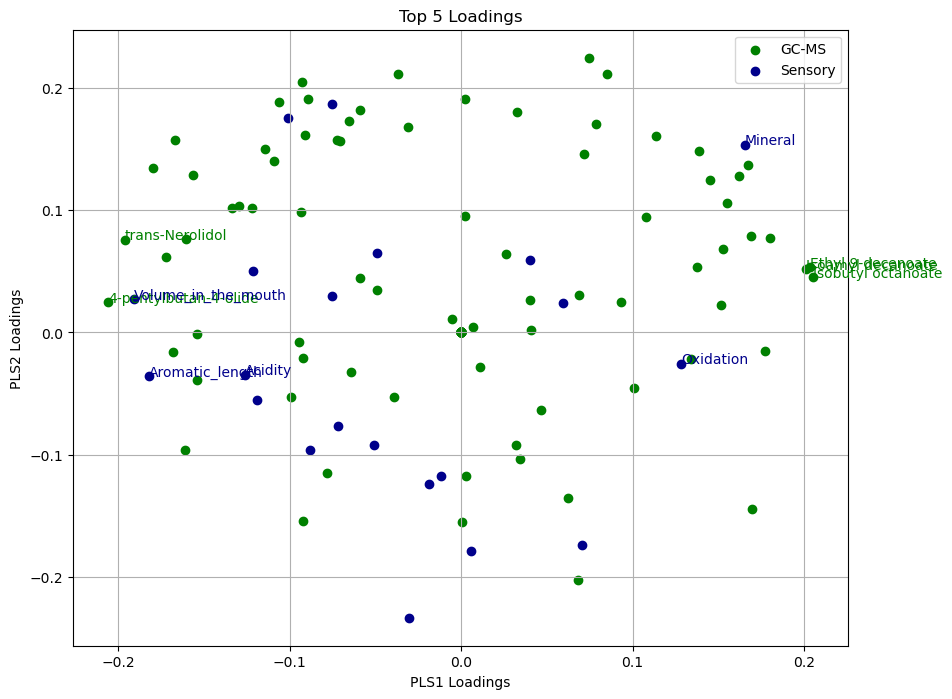

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Standardize X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Perform PLSR with 8 components
pls = PLSRegression(n_components=8)
pls.fit(X_scaled, Y_scaled)

# Get the loadings
X_loadings = pls.x_loadings_
Y_loadings = pls.y_loadings_

# Get the top 5 loadings for X and Y
top_loadings_X_idx = np.argsort(np.abs(X_loadings[:, 0]))[-5:]
top_loadings_Y_idx = np.argsort(np.abs(Y_loadings[:, 0]))[-5:]

# Create biplot
plt.figure(figsize=(10, 8))
plt.scatter(X_loadings[:, 0], X_loadings[:, 1], color='g', label='GC-MS')
plt.scatter(Y_loadings[:, 0], Y_loadings[:, 1], color='darkblue', label='Sensory')

# Plot the top 5 loadings for X and Y
for i in top_loadings_X_idx:
    plt.text(X_loadings[i, 0], X_loadings[i, 1], GC_data_cleaned.columns[i], color='g')
for i in top_loadings_Y_idx:
    plt.text(Y_loadings[i, 0], Y_loadings[i, 1], Sensory_data.columns[i], color='darkblue')

plt.xlabel('PLS1 Loadings')
plt.ylabel('PLS2 Loadings')
plt.title('Top 5 Loadings')
plt.legend()
plt.grid(True)
plt.show()


### PLSR Model quality 

Q2 is negative -->  the model is not good at predicting / generalising

It could be because your number of samples is too small during the CV process (even if you use loo, it may give you an unsufficient estimation); or, as you say, because X does not explain Y.

In [23]:
# Initialize lists to store model quality metrics
num_components = []
cumulative_Q2 = []
cumulative_X_variance = []
cumulative_Y_variance = []

# Loop over different numbers of components
for n_components in range(1, min(X.shape[1], Y.shape[1]) + 1):
    # Perform PLSR with the current number of components
    pls = PLSRegression(n_components=n_components)
    
    # Cross-validate PLSR
    y_pred = cross_val_predict(pls, X, Y, cv=10)
    
    # Calculate R^2 (Q2) score
    q2_score = r2_score(Y, y_pred)
    
    # Calculate cumulative X and Y variance explained
    pls.fit(X, Y)
    cumulative_x_var = np.cumsum(np.square(pls.x_scores_)) / np.sum(np.square(pls.x_scores_))
    cumulative_y_var = np.cumsum(np.square(pls.y_scores_)) / np.sum(np.square(pls.y_scores_))
    
    # Store metrics in lists
    num_components.append(n_components)
    cumulative_Q2.append(q2_score)
    cumulative_X_variance.append(cumulative_x_var[-1])
    cumulative_Y_variance.append(cumulative_y_var[-1])

# Create a DataFrame to store the model quality metrics
metrics_df = pd.DataFrame({
    'Number of Components': num_components,
    'Cumulative Q2': cumulative_Q2,
    'Cumulative X Variance Explained': cumulative_X_variance,
    'Cumulative Y Variance Explained': cumulative_Y_variance
})

# Print the DataFrame
metrics_df

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 8
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 8
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 8
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 8
  warnings.warn(f"Y residual is constant at iteration {k}")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.2/lib/python

,Number of Components,Cumulative Q2,Cumulative X Variance Explained,Cumulative Y Variance Explained
0,1,-0.269054,1.0,1.0
1,2,-0.225177,1.0,1.0
2,3,-0.270389,1.0,1.0
3,4,-0.346141,1.0,1.0
4,5,-0.573596,1.0,1.0
5,6,-0.724721,1.0,1.0
6,7,-0.932372,1.0,1.0
7,8,-1.071066,1.0,1.0
8,9,-1.071066,1.0,1.0
9,10,-1.071066,1.0,1.0


# WIP Pearson correlation 
not sure why I get all NaN here? 

No NaN in the data and all normalized.. 

In [21]:
# Calculate the Pearson correlation matrix 
# axis = 0 or ‘index’ to compute row-wise,
pearson_corr_matrix = GC_data_cleaned.corrwith(Sensory_data_normalized, axis=0, method='pearson')

# Display the correlation matrix
print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

Pearson Correlation Matrix:
 Nonanoic acid                                            NaN
(5Z)-Octa-1,5-dien-3-ol                                   NaN
(S)-(+)-6-Methyl-1-octanol                                NaN
1,2-Benzenedicarboxylic acid, bis(2-methylpropyl) ester   NaN
1,3-Propanediol, diacetate                                NaN
                                                           ..
White_fruit                                               NaN
trans-Geranylacetone                                      NaN
trans-Nerolidol                                           NaN
ß-Citronellol                                             NaN
ß-Damascenone                                             NaN
Length: 172, dtype: float64
